# HOMEWORK 3: Designing Closed Loop Systems

**COMMENTS**

10/10. Well done!

This homework involves designing a closed loop system with a PID controller.

In [ ]:
!pip -q install controlSBML==0.2.14
import controlSBML as ctl
import control
from controlSBML.util import makeSimulationTimes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
import tellurium as te
import sympy
print("controlSBML version: " + ctl.__version__)

controlSBML version: 0.2.14


In [ ]:
# Use the local file if it's available
BIOMD823 = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml"
ctlsb = ctl.ControlSBML(BIOMD823, input_names=['pAkt'], output_names=['pDEPTOR'])

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

**Transfer Functions**
\begin{eqnarray}
H_{RY}(s) & = & \frac{Y(s)}{R(s)} & = & \frac{C(s) G(s)}{1 + C(s) G(s) F(s)} \\
H_{RE}(s) & = & \frac{E(s)}{R(s)} & = & \frac{1}{1 + C(s) G(s) F(s)} \\
H_{NY}(s) & = & \frac{Y(s)}{N(s)} & = & -\frac{ F(s)}{1 + C(s) G(s) F(s)} \\
H_{DY}(s) & = & \frac{Y(s)}{D(s)} & = & \frac{ C(s)}{1 + C(s) G(s) F(s)} \\
\end{eqnarray}

In this homework, you will design a closed loop system for controlling pDEPTOR in the mTOR system as modelled in BioModels 823.
Use pAkt as the control input.
1. **Build**. (4 pt) Implement the function ``evaluateDesign`` that evaluates the control design of
a closed loop system for mTOR.
The evaluation is in the form of a plot of the step response of the system
to a change in the reference input.
The plot should include the reference input along with the pAkt and pDEPTO
values for the closed loop mTOR system. The function has as inputs the design parameters kp, ki, kd.
1. **Design**. (2 pt) Use ``evaluateDesign`` to design a system that has no bias for a unit step response in the reference and settles within 10 seconds.
1. **Analysis**. (3 pt) Construct the transfer function
for mTOR from pAkt to pDEPTOR
and the transfer function $H_{NY} (s)$ for the design parameters you used in (2)
(Obtain the Jacobian at time 1 from the open loop mTOR system.)
Use these transfer functions to answer the following questions about how the closed loop system should behave *in theory*.
   1. Why are large control inputs required to control the mTOR system?
   1. Why are there no long term oscillations in the closed loop system?
   1. How will a step increase in noise affect the output of the closed loop system?
1. **Discussion**. (1 pt) Plot the values of pAkt for the closed loop system you designed in (2).
What issues do you see with using this closed loop system in practice?

# Q1. Build

In [ ]:
def evaluateDesign(kp, ki, kd, kf=-1, system_model=BIOMD823, input_name='pAkt', 
                   output_name='pDEPTOR', reference=1, noise_values=[0.05, 20.0], 
                   disturbance_values=[0.05, 2.0], simulation_times=[0,40,100], 
                   plot_y_limits=None):
  """
  This function evaluates the effect of a given set of PID control parameters on a
  user-provided SISO model in a closed-loop system by plotting the reference 
  input, system input, and system output in response to a given reference value.

  Parameters
  ----------
  kp: A float containing the proportional control constant for a PID controller
  ki: A float containing the integral control constant for a PID controller
  kd: A float containing the derivative control constant for a PID controller
  kf: A float containing the exponential value to be used in a filter for the 
  closed loop system. Defaults to -1.
  system_model: An SBML model describing the system to be controlled in the closed 
  loop. Defaults to BIOMD823, describing an mTor system.
  input_name: A string containing the name of the control input in the system 
  model. Defaults to 'pAkt'.
  output_name: A string containing the name of the control output in the system 
  model. Defaults to 'pDEPTOR'.
  reference: A numeric value containing the reference input used to control the 
  system. Default to 1.
  noise_values: A list containing, in order, the magnitude and the frequency of the 
  simulated output noise in the closed loop system, represented as floats. 
  Defaults to [0.05, 20].
  disturbance_values: A list of containing, in order, the magnitude and the 
  frequency of the simulated control value disturbance in the closed loop system, 
  represented as floats. Defaults to [0.05, 2].
  simulation_times: A list of numeric values containing, in order, the starting 
  time, ending time, and number of time points per unit of time to be used in the 
  simulation of the closed loop system. Defaults to [0, 40, 100].
  plot_y_limits: A list of numeric values containing, in order, the lower and 
  upper bound of y-axis values to be displayed on the plot. If None, uses 
  pyplot's default axis scaling. Defaults to None.

  Returns
  -------
  closed_loop_analysis: A list containing three objects.
  At index 0, a pyplot figure object showing the reference, system input, and system output over time.
  At index 1, the TimeResponseData object created by running a simulation of the closed loop system. 
  And at index 2, the InterconnectedSystem object containing the closed loop system.
  """
  ### Creating objects to be included in the closed loop
  # Creating NonlinearIOSystem object for the biomodel system of interest
  ctlsb = ctl.ControlSBML(system_model, input_names=[input_name], output_names=[output_name])
  system = ctlsb.makeNonlinearIOSystem("system")
  # Creating factory to generate PID controller and filter objects
  factory = ctl.IOSystemFactory()
  controller = factory.makePIDController("controller", kp=kp, ki=ki, kd=kd)
  filter = factory.makeFilter("filter", constant=kf)
  # Creating generators for disturbance and noise
  noise = factory.makeSinusoid("noise", noise_values[0], noise_values[1])
  disturbance = factory.makeSinusoid("disturbance", disturbance_values[0], disturbance_values[1])
  # Creating Adder objects to calculate error, introduce disturbance, and introduce noise
  sum_output_noise = factory.makeAdder("sum_output_noise")
  sum_control_disturbance = factory.makeAdder("sum_control_disturbance")
  sum_reference_filter = factory.makeAdder("sum_reference_filter")

  ### Assembling closed loop with interconnects
  # Creating system input/output name strings
  system_input = "system.%s" % input_name
  system_output = "system.%s" % output_name
  # Creating interconnect object
  closed_loop = control.interconnect(
    [noise, disturbance, sum_output_noise, sum_control_disturbance, sum_reference_filter, system, filter, controller], 
    connections=[
      ['controller.in', 'sum_reference_filter.out'],      # passing error into controller
      ['sum_control_disturbance.in1', 'controller.out'],  # passing controller output into control/disturbance adder
      ['sum_control_disturbance.in2', 'disturbance.out'], # passing disturbance output into control/disturbance adder
      [system_input,   'sum_control_disturbance.out'],   # passing control with disturbance to system input
      ['sum_output_noise.in1', system_output],         # passing system output into output/noise adder
      ['sum_output_noise.in2', 'noise.out'],              # passing noise output into output/noise adder
      ['filter.in',     'sum_output_noise.out'],          # passing output with noise into filter input
      ['sum_reference_filter.in1', '-filter.out'],        # passing inverted filter output into reference/filter adder
    ],
    inplist=["sum_reference_filter.in2"],
    outlist=["sum_reference_filter.in2", system_input, system_output],
  )

  ### Running simulation of closed loop control system
  X0 = ctl.makeStateVector(closed_loop)
  #print(ctlsb.makeTransferFunction())
  simulation_times = ctl.makeSimulationTimes(simulation_times[0], simulation_times[1], simulation_times[2])
  result = control.input_output_response(closed_loop, T=simulation_times, U=reference, X0=X0)

  ### Creating plot of reference and system values
  # Creating figure object to return
  fig = plt.figure()
  plt.plot(result.t, result.outputs[0].flatten())
  plt.plot(result.t, result.outputs[1].flatten())
  plt.plot(result.t, result.outputs[2].flatten())
  plt.legend(["Reference", input_name, output_name])
  plt.title("Closed Loop Response to Input of " + str(reference) +  " With kp=" + str(kp) + ", ki=" + str(ki) + ", and kd=" + str(kd))
  plt.xlabel("Time")
  plt.ylabel("Closed Loop State Value")
  if plot_y_limits != None:
    plt.ylim(plot_y_limits)
  plt.close()
  
  # Returning plot, simulation results, and closed_loop
  closed_loop_analysis = [fig, result, closed_loop]
  return closed_loop_analysis

#Tests
test_results = evaluateDesign(0,2,0, simulation_times=[0,55,100])
# Check that the function returns a figure object
assert(type(test_results[0]) == type(plt.figure()))
# Check that the function returns a TimeResponseData object of results, with the expected start and end times
assert(test_results[1].t[0] == 0.0)
assert(test_results[1].t[-1] == 55.0)
# Check that the function returns an InterconnectedSystem object with the expected components
assert(test_results[2].syslist[0].name == 'noise')
assert(test_results[2].syslist[1].name == 'disturbance')
assert(test_results[2].syslist[7].name == 'controller')
print("Tests Passed!")

Tests Passed!


<Figure size 432x288 with 0 Axes>

#### Function Testing Code

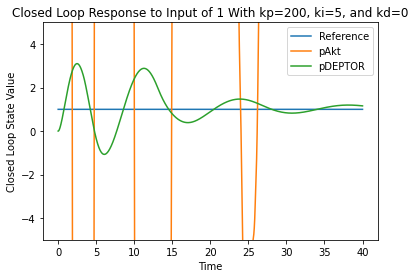

In [ ]:
#@title
f = evaluateDesign(200,5,0,plot_y_limits=[-5,5])
f[0]

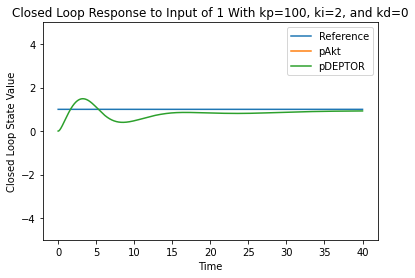

In [ ]:
#@title
f = evaluateDesign(100,2,0, plot_y_limits=[-5,5])
f[0]

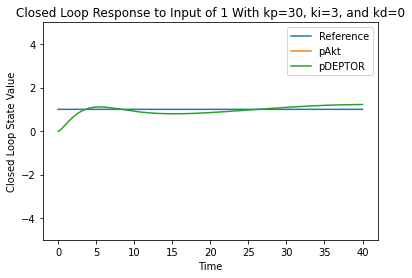

In [ ]:
#@title
f = evaluateDesign(30,3,0, plot_y_limits=[-5,5], simulation_times=[0,40,50])
f[0]
# W o W !!!!!

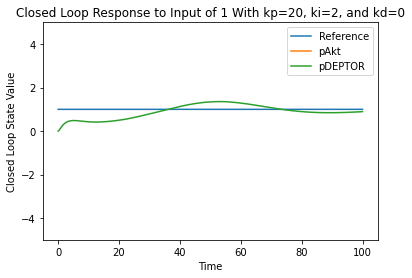

In [ ]:
#@title
f = evaluateDesign(20,2,0, simulation_times=[0,100,50], plot_y_limits=[-5,5])
f[0]

# Q2. Design

Since the objectives of this controller are to eliminate bias and to settle within 10 seconds, I first started by increasing integral control (by multiples of 1) until pDEPTOR values crossed the reference line.

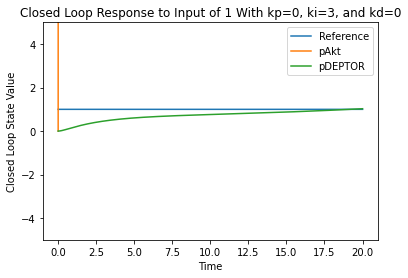

In [ ]:
f = evaluateDesign(0,3,0, plot_y_limits=[-5,5], simulation_times=[0, 20, 100])
f[0]

After this, I increased proportional control (by multiples of 10) until the time to converge to the reference was low. Despite not being part of the controller's necessary behavior, I avoided increasing proportional control to a level where overshoot exceeded twice the reference.

Had this not resulted in a settling time lower than 10 seconds, I would have begun increasing derivative and proprtional control while decreasing integral control.

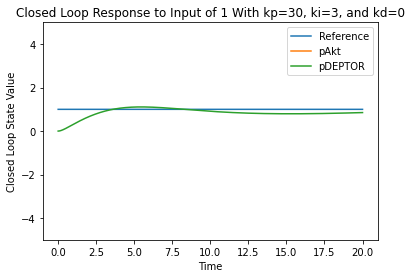

In [ ]:
f = evaluateDesign(30,3,0, plot_y_limits=[-5,5], simulation_times=[0,20,100])
f[0]

However, the above PI controller *does* meet both the bias and settling time requirements, making the implementation of derivative control unnecessary.

# Q3. Analyze

In [ ]:
#@title
def plotTFs(Gs, kp=0, ki=0, kd=0, times=ctl.makeSimulationTimes(0, 5, 500), ylim=None, title=None, is_plot=True):
    """
    Constructs the transfer functions for the proportional controller, and filter.
    Calculates the transfer functions HRYs, HREs, HNYs, HDYs and plots them.
    
    Parameters
    ----------
    Gs: control.TransferFunction
    kp: float
    ki: float
    kd: float
    times: list-float
    ylim: (float, float)
        limits of y-values
    title: str
    
    Returns
    -------
    dct
        key: name of transfer function
        value: control.TransferFunction
    """
    Cs = control.TransferFunction([kp], [1]) + control.TransferFunction([ki], [1, 0])  \
        + control.TransferFunction([kd, 0], [1])
    Fs = 1
    denom = 1 + Cs*Gs*Fs
    # Construct the transfer functions
    tf_dct = {
        "HRYs": Cs*Gs/denom,
        "HREs": 1/denom,
        "HNYs": -Fs/denom,
        "HDYs": Cs/denom,
    }
    # Construct the plots
    _, ax = plt.subplots(1)
    for tf in tf_dct.values():
        result = control.forced_response(tf, T=times, U=1)
        plt.plot(result.t.flatten(), result.y.flatten())
    # Refine plots
    plt.legend(list(tf_dct.keys()))
    xmax = max(result.t.flatten())
    plt.plot([0, xmax], [0, 0], linestyle="--", color="black")
    plt.plot([0, xmax], [1, 1], linestyle="--", color="grey")
    plt.ylim([-5, 5])
    title = "kp=%2.2f ki=%2.2f kd=%2.2f" % (kp, ki, kd)
    plt.title(title)
    if not is_plot:
        plt.close()
    return tf_dct
    
# Tests
Gs = control.TransferFunction([2], [1, 3])
dct = plotTFs(Gs, kp=10, ylim=[0, 3], title="Example", is_plot=False)
assert(len(dct) == 4)
assert("TransferFunction" in str(type(dct["HRYs"])))
print("OK!")

OK!


In [ ]:
# Displaying transfer function from pAkt to pDEPTOR
Gs = ctlsb.makeTransferFunction(time=1)
Gs

TransferFunction(array([-5.32907052e-15,  1.21077564e-02,  2.66599153e-02,  1.57111954e-02,
        3.18977913e-03,  1.79505596e-04,  3.83624437e-06,  2.80222040e-08]), array([1.00000000e+00, 8.77219555e+00, 1.91921294e+01, 1.63360045e+01,
       6.19328093e+00, 1.00072931e+00, 5.29014911e-02, 1.10124075e-03,
       7.93318042e-06]))

From the above transfer function from pAkt to pDEPTOR, we can see that the system has a remarkably low DC gain, with the numerator's constant being over two orders of magnitude lower than the denominator.

From this, we can say that changing pAkt has a small effect on pDEPTOR. It it likely for this reason that the PID control parameters need to be so large, as small parameters would not be able to induce a large change in pDEPTOR's value by manipulating pAkt.

In [ ]:
Gs.pole()

/usr/local/lib/python3.7/dist-packages/scipy/signal/filter_design.py:1632: BadCoefficients:

Badly conditioned filter coefficients (numerator): the results may be meaningless



array([-5.99897067+0.j        , -1.40789094+0.j        ,
       -0.57152286+0.j        , -0.42693364+0.j        ,
       -0.29423828+0.j        , -0.03259074+0.j        ,
       -0.02002421+0.00068193j, -0.02002421-0.00068193j])

From the above poles, we can see that the uncontrolled system has no purely imaginary or positive complex poles. As such, any oscillations in the system will decay to zero.

Since the system itself does not have any long-term oscillations, the closed loop does not need to correct it, and will itself be free of long-term oscillations so long as the control parameters are not large enough to introduce positive poles.

In [ ]:
# Displaying transfer function from noise to output
tf_dict = plotTFs(Gs, kp=30, ki=3, kd=0, is_plot=False)
tf_dict["HNYs"]

TransferFunction(array([-1.00000000e+00, -8.77219555e+00, -1.91921294e+01, -1.63360045e+01,
       -6.19328093e+00, -1.00072931e+00, -5.29014911e-02, -1.10124075e-03,
       -7.93318042e-06,  0.00000000e+00]), array([1.00000000e+00, 8.77219555e+00, 1.95553621e+01, 1.71721253e+01,
       6.74459654e+00, 1.14355627e+00, 6.78559963e-02, 1.75484487e-03,
       2.02825796e-05, 8.40666120e-08]))

In [ ]:
tf_dict["HNYs"].dcgain()

0.0

Bafflingly, the DC gain of the above transfer function from noise to output at time=1 is zero, which implies that a unit step increase in the noise in the closed loop will have no discernible effect on the output.

# Q4. Discussion

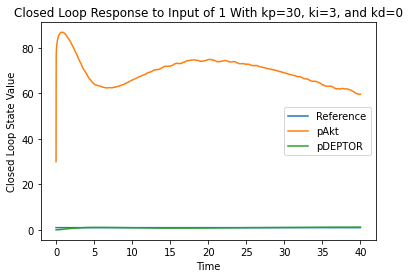

In [ ]:
f = evaluateDesign(30,3,0)
f[0]

In the above plot, it can be seen that the pAkt values in this controller are disturbingly large and change at concerningly fast rates. While this controller is highly effective in theory, it would be difficult to implement in a real world system. An extraordinarily large amount of pAkt would need to be supplied to the system and its concentration would need to be altered somewhat quickly.

While this system is not impossible to implement in practice, given that pAkt's concentration is always positive and undergoes small changes relative to its average value over time, it runs the risk of being too costly to implement due to the equipment and reagents needed to maintain these input values.

Given the small effect that pAkt has on pDEPTOR however, this is likely unavoidable. The only way to avoid such large input values would be to select a different system input.